In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import datacube
from datacube.utils import geometry
import numpy as np
import geopandas as gpd

import sys
sys.path.append('../Scripts')
from deafrica_spatialtools import xr_rasterize


In [2]:
dc = datacube.Datacube()

In [3]:
import glob, os

areas = glob.glob('data/AEZs/Indian_ocean.shp')

Indian_ocean
Rasterizing to match xarray.DataArray dimensions (57389, 24975) and projection system/CRS (e.g. PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 Global",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Cylindrical_Equal_Area"],PARAMETER["standard_parallel_1",30],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","6933"]])
CPU times: user 1min 44s, sys: 24.1 s, total: 2min 8s
Wall time: 50 s


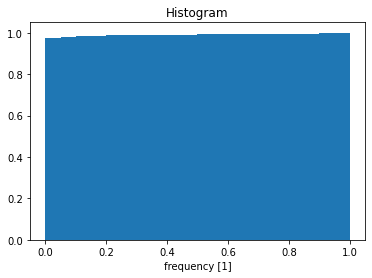

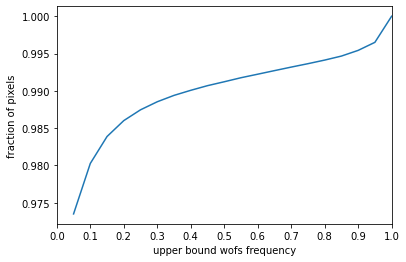

In [4]:
%%time

for aez_region in areas:
    name = aez_region.split('/')[-1].split('.')[0]
    if os.path.exists(f'wofs_summary_aez/wofs_{name}.csv'): continue
    if name in ['Sahel', 'Northern','Southern']: continue
    print(name)
    aez=gpd.read_file(aez_region)
    geom = geometry.Geometry(aez.iloc[0].geometry.__geo_interface__,
                             geometry.CRS(f'EPSG:{aez.crs.to_epsg()}'))
    # load wofs
    wofs = dc.load(product='ga_ls8c_wofs_2_summary', measurements=['frequency'], dask_chunks={'x':2000,'y':2000}, geopolygon=geom).squeeze()
    # clip
    mask = xr_rasterize(gdf=aez, da=wofs.frequency)
    clipped_wofs = wofs.where(mask)
    
    histy, histx, temp = clipped_wofs.frequency.plot.hist(bins=np.arange(0.0,1.05,0.05), cumulative=True, density=True)
    np.savetxt(f'wofs_{name}.csv', np.vstack((histx[1:], histy)).transpose(),fmt='%.3f', delimiter=',')
    
    fig=plt.figure()
    plt.plot(histx[1:],histy)
    plt.xlim((0,1))
    plt.xticks(np.arange(0,1.05,0.1))
    plt.xlabel('upper bound wofs frequency')
    plt.ylabel('fraction of pixels')
    plt.savefig(f'wofs_{name}.png')

    
    continue
    # for bigger regions
    bins = np.arange(0.1,1.05,0.1)
    cum_count = []
    for upper in bins:
        cum_count.append((clipped_wofs.frequency<upper).sum().values)
    cum_count = np.array(cum_count)
    cum = cum_count/cum_count[-1]
    np.savetxt(f'wofs_{name}.csv', np.vstack((bins[1:], cum, cum_count)).transpose(),fmt='%.2f, %.3f, %d', delimiter=',')
    